# Продолжение 2

# ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА

слушателя курса "Data Science"

Образовательного центра

Московского государственного технического университета им. Н.Э. Баумана

Старостиной Ярославы Константиновны

In [35]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf

from numpy.random import seed
from pandas import read_excel, DataFrame, Series
from scipy import stats

from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing

from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel(r"C:\Users\Ярослава\Untitled Folder\Датасет для ВКР_композиты\itog.xlsx")

Предобработка данных

In [5]:
#Пропуски в данных отсутствуют. Значит, сразу приступаем к работе с выбросами
df.isna().sum()

Unnamed: 0                              0
Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

Почему необходимо удалить выбросы от данных?

Выбросы являются точками данных, которые лежат вдали от обычного распределения данных и приводит к тому, что ниже воздействие на общее распределение данных:

-Влияет на общую стандартную вариацию данных.

-Манипулирует общее среднее значение данных.

-Преобразует данные в перекошенную форму.

-Это вызывает смещение в оценке точности модели обучения машины.

-Влияет на распределение и статистику набора данных.

Из-за вышеуказанных причин необходимо обнаружить и избавиться от выбросов до моделирования набора данных.

#Для удаления выбросов существует 2 основных метода:
#- метод 3-х сигм
#- метод межквартильных расстояний. 
metod_3s = 0
metod_iq = 0
count_iq = [] # Список для фиксирования количества выбросов по каждой колонке датафрейма.
count_3s = [] # Список для фиксирования количества выбросов по каждой колонке датафрейма.
for column in df:
    d = df.loc[:, [column]]
    # методом 3-х сигм
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    metod_3s += d['3s'].sum()
    count_3s.append(d['3s'].sum())
    print(column,'3s', ': ', d['3s'].sum())

    # методом межквартильных расстояний
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (df[column] <= lower) | (df[column] >= upper)
    metod_iq += d['iq'].sum()
    count_iq.append(d['iq'].sum())
    print(column, ': ', d['iq'].sum())
print('Метод 3-х сигм, выбросов:', metod_3s)
print('Метод межквартильных расстояний, выбросов:', metod_iq)

In [6]:
komposit = df.copy()
for i in df.columns:
    komposit[i] = abs((df[i] - df[i].mean()) / df[i].std())
    print(f"{sum(komposit[i] > 3)} выбросов в признаке {i}")
print(f' Всего {sum(sum(komposit.values > 3))} выброса')

0 выбросов в признаке Unnamed: 0
0 выбросов в признаке Соотношение матрица-наполнитель
3 выбросов в признаке Плотность, кг/м3
2 выбросов в признаке модуль упругости, ГПа
2 выбросов в признаке Количество отвердителя, м.%
2 выбросов в признаке Содержание эпоксидных групп,%_2
3 выбросов в признаке Температура вспышки, С_2
2 выбросов в признаке Поверхностная плотность, г/м2
0 выбросов в признаке Модуль упругости при растяжении, ГПа
0 выбросов в признаке Прочность при растяжении, МПа
3 выбросов в признаке Потребление смолы, г/м2
0 выбросов в признаке Угол нашивки, град
0 выбросов в признаке Шаг нашивки
7 выбросов в признаке Плотность нашивки
 Всего 24 выброса


In [8]:
# Исключим выбросы, очистим данные от выбросов методом межквартильного расстояния (далее 1,5 межквартильных размахов)
for i in df.columns:
    q75, q25 = np.percentile(df.loc[:,i], [75,25])
    intr_qr = q75 - q25
    max = q75 + (1.5 * intr_qr)
    min = q25 - (1.5 * intr_qr)
    df.loc[df[i] < min, i] = np.nan
    df.loc[df[i] > max, i] = np.nan
df.isna().sum()

Unnamed: 0                               0
Соотношение матрица-наполнитель          6
Плотность, кг/м3                         9
модуль упругости, ГПа                    2
Количество отвердителя, м.%             14
Содержание эпоксидных групп,%_2          2
Температура вспышки, С_2                 8
Поверхностная плотность, г/м2            2
Модуль упругости при растяжении, ГПа     6
Прочность при растяжении, МПа           11
Потребление смолы, г/м2                  8
Угол нашивки, град                       0
Шаг нашивки                              4
Плотность нашивки                       21
dtype: int64

In [9]:
df

Unnamed: 0  Соотношение матрица-наполнитель  Плотность, кг/м3  \
0            0.0                         1.857143       2030.000000   
1            1.0                         1.857143       2030.000000   
2            2.0                         1.857143       2030.000000   
3            3.0                         1.857143       2030.000000   
4            4.0                         2.771331       2030.000000   
...          ...                              ...               ...   
1018      1018.0                         2.271346       1952.087902   
1019      1019.0                         3.444022       2050.089171   
1020      1020.0                         3.280604       1972.372865   
1021      1021.0                         3.705351       2066.799773   
1022      1022.0                         3.808020       1890.413468   

      модуль упругости, ГПа  Количество отвердителя, м.%  \
0                738.736842                          NaN   
1                738.736842                    50.000000   
2                738.736842                    49.900000   
3                738.736842                   129.000000   
4                753.000000                   111.860000   
...                     ...                          ...   
1018             912.855545                    86.992183   
1019             444.732634                   145.981978   
1020             416.836524                   110.533477   
1021             741.475517                   141.397963   
1022             417.316232                   129.183416   

      Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                           22.267857                       NaN   
1                           23.750000                284.615385   
2                                 NaN                284.615385   
3                           21.250000                300.000000   
4                           22.267857                284.615385   
...                               ...                       ...   
1018                        20.123249                324.774576   
1019                        19.599769                254.215401   
1020                        23.957502                248.423047   
1021                        19.246945                275.779840   
1022                        27.474763                300.952708   

      Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                        210.000000                             70.000000   
1                        210.000000                             70.000000   
2                        210.000000                             70.000000   
3                        210.000000                             70.000000   
4                        210.000000                             70.000000   
...                             ...                                   ...   
1018                     209.198700                             73.090961   
1019                     350.660830                             72.920827   
1020                     740.142791                             74.734344   
1021                     641.468152                             74.042708   
1022                     758.747882                             74.309704   

      Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0                       3000.000000               220.000000   
1                       3000.000000               220.000000   
2                       3000.000000               220.000000   
3                       3000.000000               220.000000   
4                       3000.000000               220.000000   
...                             ...                      ...   
1018                    2387.292495               125.007669   
1019                    2360.392784               117.730099   
1020                    2662.906040               236.606764   
1021                    2071.715856               197.126067  

In [11]:
df = df.fillna(df.median()) # замена пустых значений на медиану

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            1023 non-null   float64
 1   Соотношение матрица-наполнитель       1023 non-null   float64
 2   Плотность, кг/м3                      1023 non-null   float64
 3   модуль упругости, ГПа                 1023 non-null   float64
 4   Количество отвердителя, м.%           1023 non-null   float64
 5   Содержание эпоксидных групп,%_2       1023 non-null   float64
 6   Температура вспышки, С_2              1023 non-null   float64
 7   Поверхностная плотность, г/м2         1023 non-null   float64
 8   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 9   Прочность при растяжении, МПа         1023 non-null   float64
 10  Потребление смолы, г/м2               1023 non-null   float64
 11  Угол нашивки, гра

In [14]:
df.describe().T

count         mean         std  \
Unnamed: 0                            1023.0   511.000000  295.458965   
Соотношение матрица-наполнитель       1023.0     2.925146    0.892296   
Плотность, кг/м3                      1023.0  1974.778867   70.843002   
модуль упругости, ГПа                 1023.0   737.724320  326.453977   
Количество отвердителя, м.%           1023.0   110.558141   26.661661   
Содержание эпоксидных групп,%_2       1023.0    22.241659    2.369521   
Температура вспышки, С_2              1023.0   285.949096   39.355511   
Поверхностная плотность, г/м2         1023.0   480.886331  278.400394   
Модуль упругости при растяжении, ГПа  1023.0    73.310778    3.042662   
Прочность при растяжении, МПа         1023.0  2465.685723  465.480291   
Потребление смолы, г/м2               1023.0   218.089766   57.681964   
Угол нашивки, град                    1023.0    44.252199   45.015793   
Шаг нашивки                           1023.0     6.870613    2.521972   
Плотность нашивки                     1023.0    57.414813   11.142801   

                                              min          25%          50%  \
Unnamed: 0                               0.000000   255.500000   511.000000   
Соотношение матрица-наполнитель          0.547391     2.321061     2.906383   
Плотность, кг/м3                      1784.482245  1924.535020  1977.450684   
модуль упругости, ГПа                    2.436909   500.047452   738.957167   
Количество отвердителя, м.%             38.668500    92.883002   110.564840   
Содержание эпоксидных групп,%_2         15.695894    20.615227    22.230744   
Температура вспышки, С_2               179.374391   259.372264   285.896812   
Поверхностная плотность, г/м2            0.603740   266.816645   451.313045   
Модуль упругости при растяжении, ГПа    65.553336    71.287231    73.264735   
Прочность при растяжении, МПа         1250.392802  2146.295983  2457.959767   
Потребление смолы, г/м2                 63.685698   179.932410   219.179155   
Угол нашивки, град                       0.000000     0.000000     0.000000   
Шаг нашивки                              0.000000     5.080033     6.908628   
Плотность нашивки                       27.272928    50.277138    57.516472   

                                              75%          max  
Unnamed: 0                             766.500000  1022.000000  
Соотношение матрица-наполнитель          3.548775     5.314144  
Плотность, кг/м3                      2020.628746  2161.565216  
модуль упругости, ГПа                  957.386959  1649.415706  
Количество отвердителя, м.%            129.233303   181.828448  
Содержание эпоксидных групп,%_2         23.961468    28.955094  
Температура вспышки, С_2               312.586724   386.067992  
Поверхностная плотность, г/м2          691.775979  1291.340115  
Модуль упругости при растяжении, ГПа    75.322176    81.417126  
Прочность при растяжении, МПа         2755.823091  3705.672523  
Потребление смолы, г/м2                256.760915   359.052220  
Угол нашивки, град                      90.000000    90.000000  
Шаг нашивки                              8.575956    13.732404  
Плотность нашивки                       64.588169    86.012427

In [19]:
# boxplot
for column in df.columns:
    fig = px.box(df, y = column)
    fig.show()

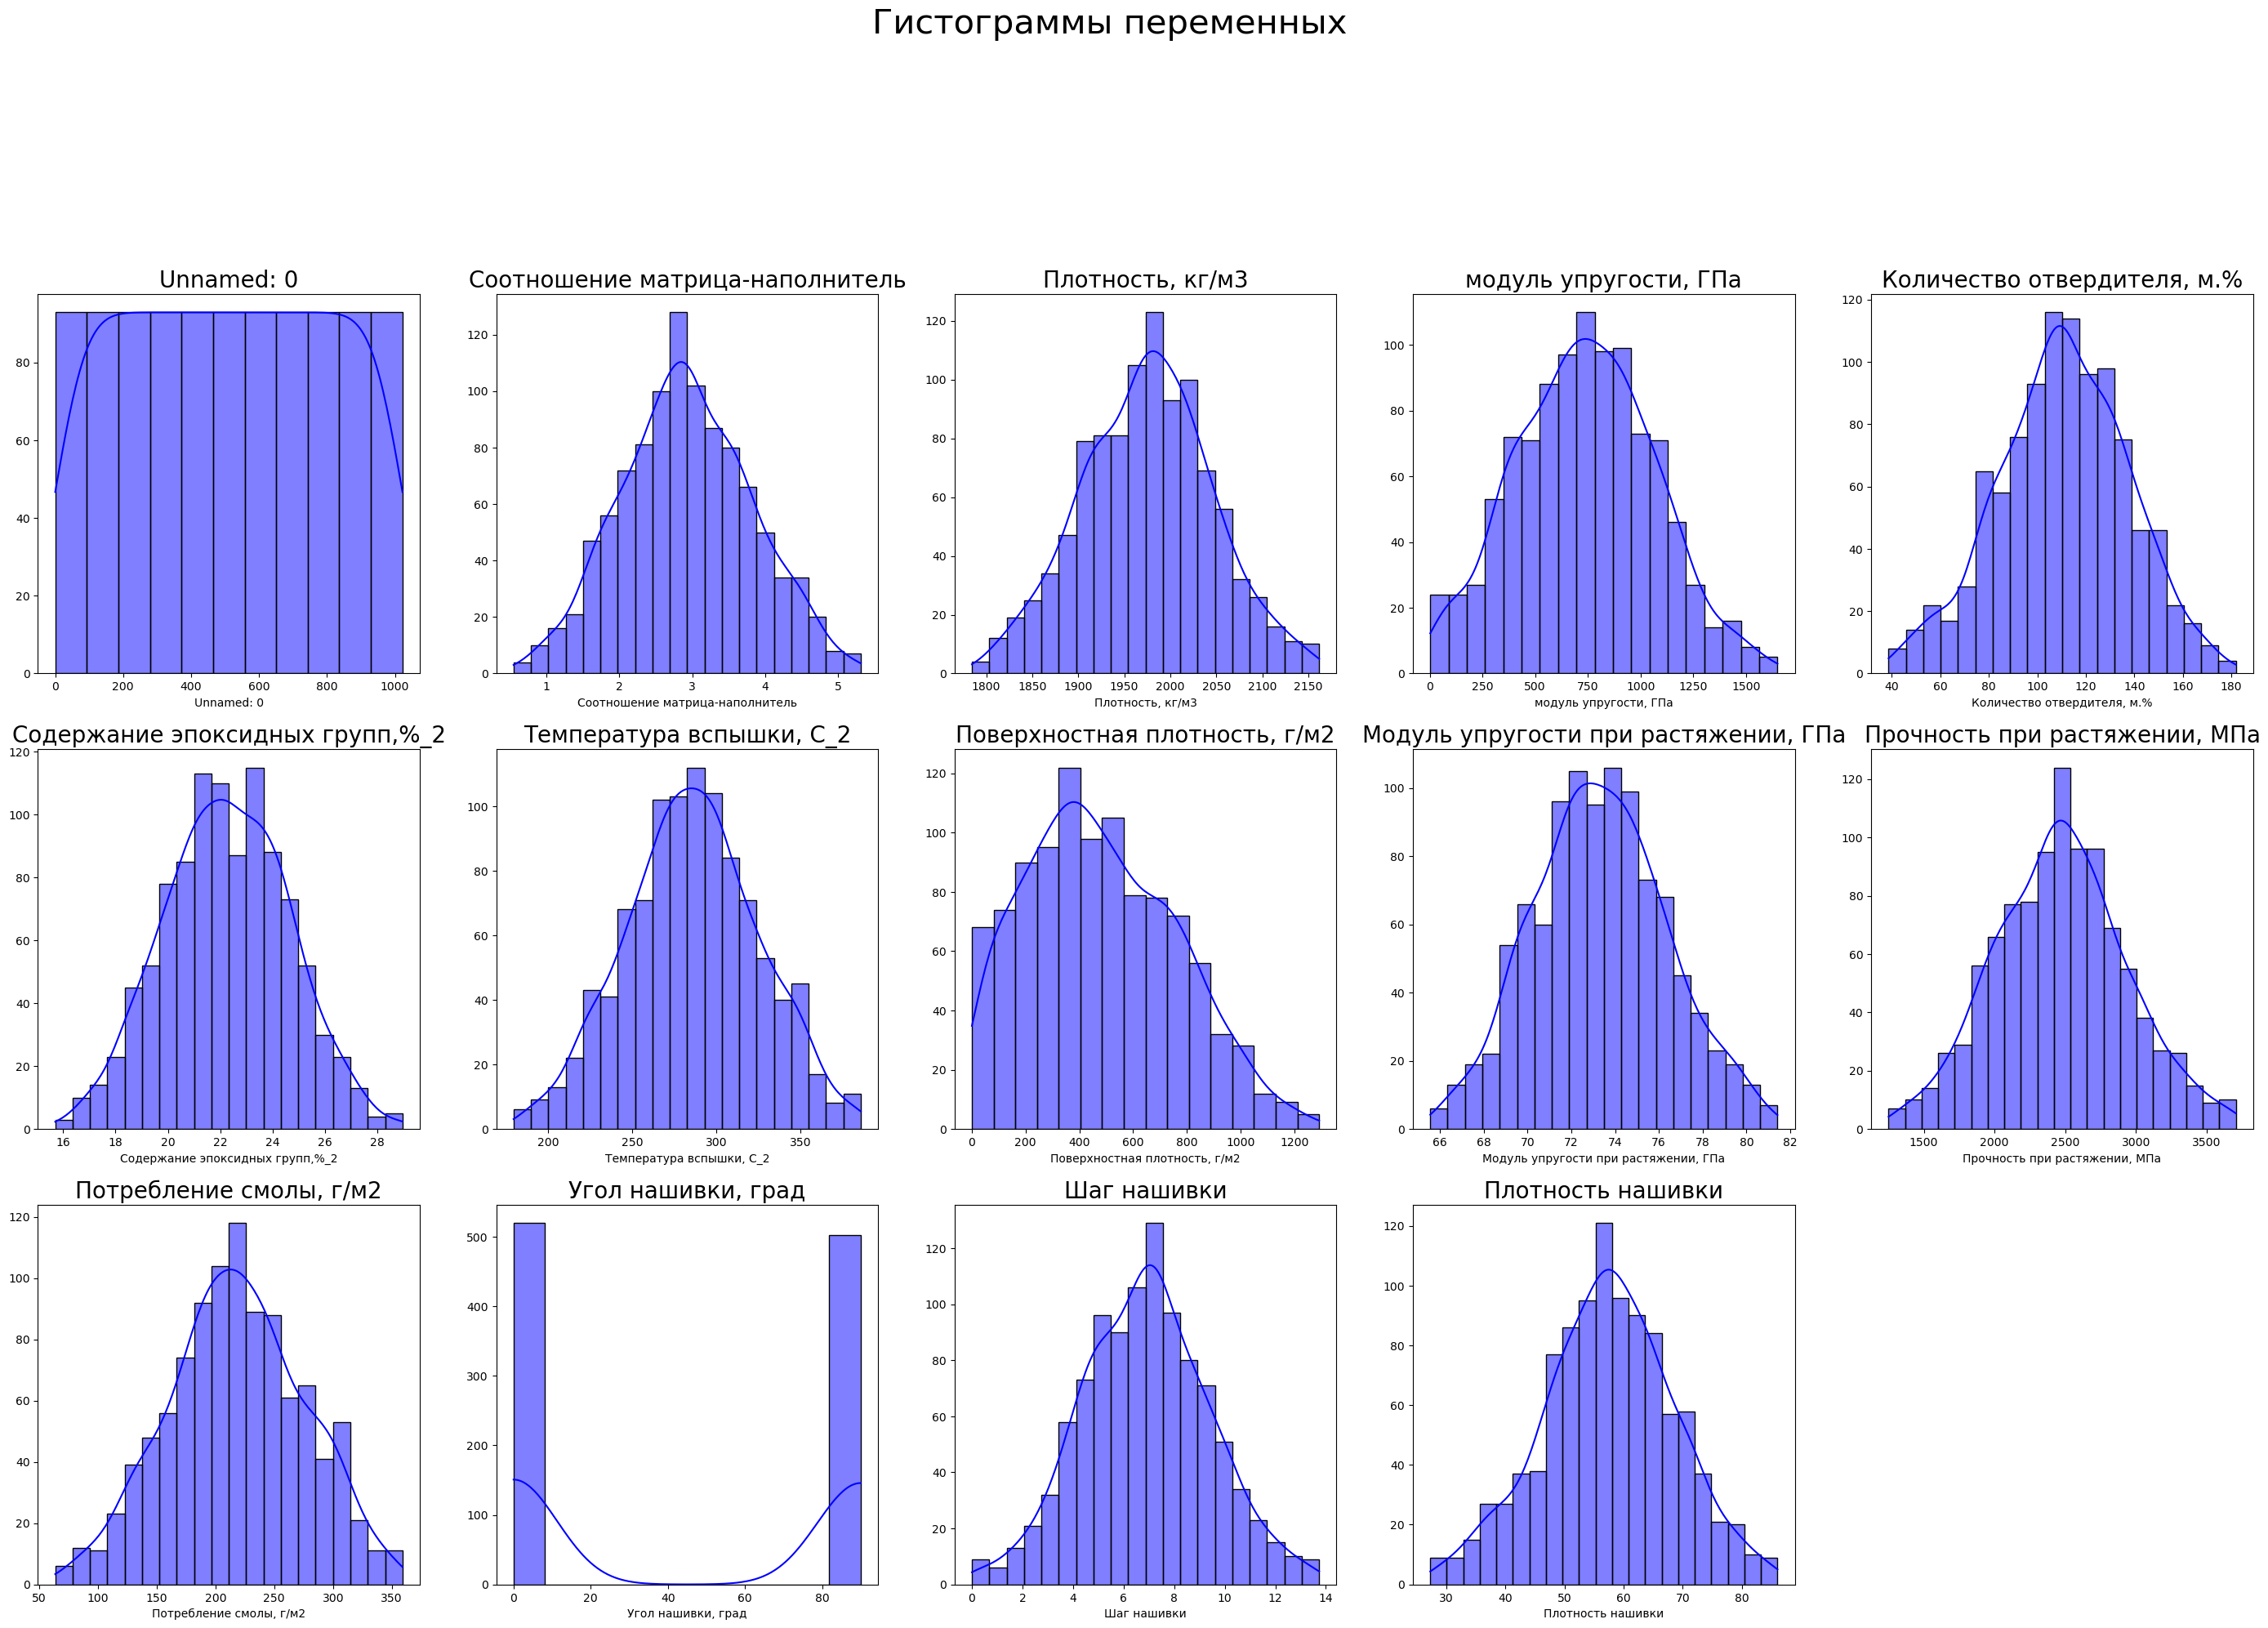

In [20]:
# Гистограмма распределения
a = 5 # количество строк
b = 5 # количество столцбцов
c = 1 # инициализация plot counter
plt.figure(figsize = (35,35))
plt.suptitle('Гистограммы переменных', fontsize = 30)
for col in df.columns:
    plt.subplot(a, b, c)
    #plt.figure(figsize=(7,5))
    sns.histplot(data = df[col], kde=True, color = "blue")
    plt.ylabel(None)
    plt.title(col, size = 20)
    #plt.show()
    c += 1 

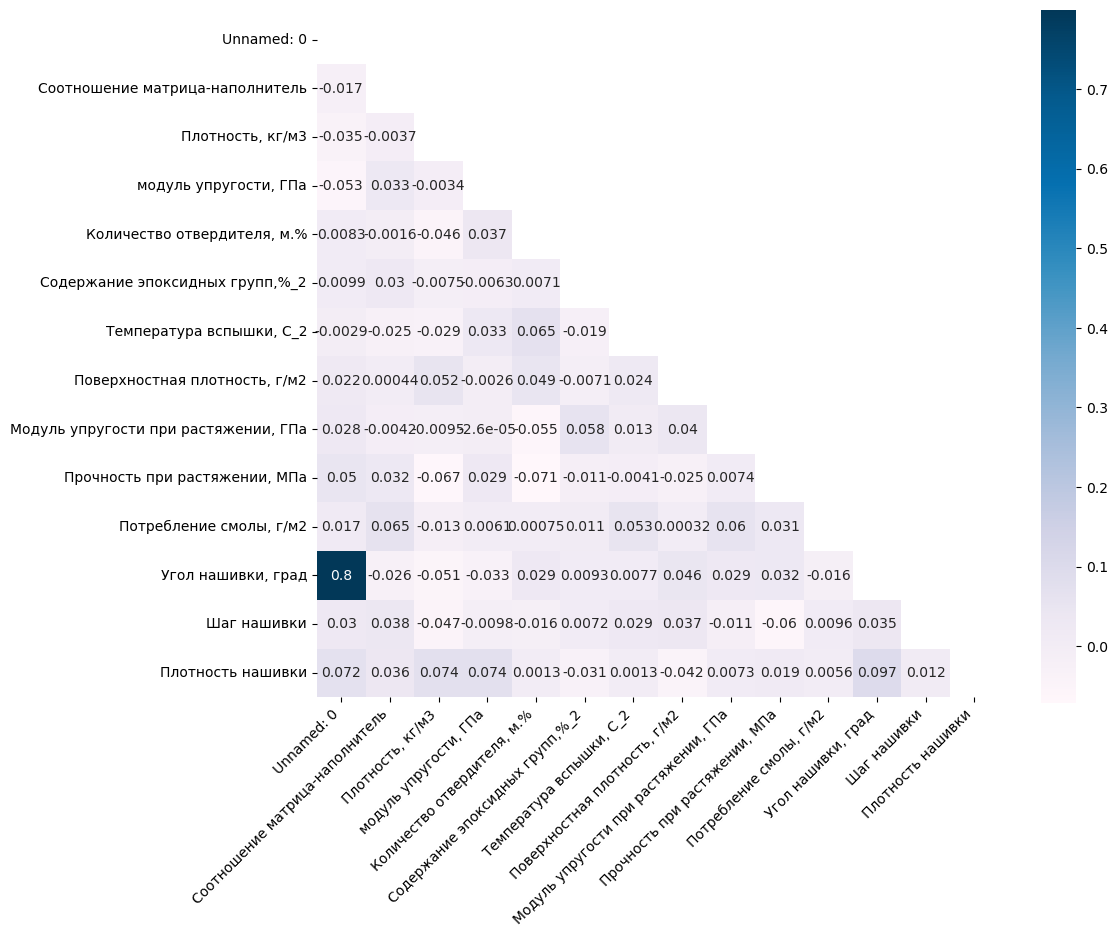

In [18]:
#Визуализация корреляционной матрицы с помощью тепловой карты
mask = np.triu(df.corr())
# Создаем полотно для отображения большого графика
f, ax = plt.subplots(figsize = (11, 9))
# # Визуализируем данные кореляции и создаем цветовую палитру
sns.heatmap(df.corr(), mask = mask, annot = True, square = True, cmap = 'PuBu')
plt.xticks(rotation = 45, ha='right')
plt.show()

In [23]:
#Сохраняем идеальный, без выбросов датасет
df.to_csv("Датасет для ВКР_композиты\Itog.csv", encoding = 'cp1251' )
df.to_excel("Датасет для ВКР_композиты\Itog.xlsx")

Предобработка данных.
Нормализуем данные

У нас в основном количественные признаки, поэтому можно применить нормализацию (приведение в диапазон от 0 до 1) или стандартизацию (приведение к матожиданию 0, стандартному отклонению 1). Т.к. это в том числе учебная работа, то используем и нормализацию, и стандартизацию.

Почему нам нужно нормализовать данные?

Алгоритмы машинного обучения, как правило, работают лучше или сходятся быстрее, когда различные функции (переменные) имеют меньший масштаб. Поэтому перед обучением на них моделей машинного обучения данные обычно нормализуются.

Нормализация также делает процесс обучения менее чувствительным к масштабу функций. Это приводит к улучшению коэффициентов после тренировки.

Этот процесс повышения пригодности функций для обучения путем изменения масштаба называется масштабированием функций.

Мы вычитаем минимальное значение из каждой записи, а затем делим результат на диапазон. Где диапазон - это разница между максимальным значением и минимальным значением.

In [25]:
#Нормализуем данные с помощью MinMaxScaler() 
MMScaler = preprocessing.MinMaxScaler()
columns = df.columns
result = MMScaler.fit_transform(df)

df_minmax = pd.DataFrame(result, columns = columns)
df_minmax.describe()

Unnamed: 0  Соотношение матрица-наполнитель  Плотность, кг/м3  \
count  1023.000000                      1023.000000       1023.000000   
mean      0.500000                         0.498821          0.504655   
std       0.289099                         0.187192          0.187871   
min       0.000000                         0.000000          0.000000   
25%       0.250000                         0.372092          0.371411   
50%       0.500000                         0.494885          0.511740   
75%       0.750000                         0.629650          0.626245   
max       1.000000                         1.000000          1.000000   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean                0.446446                     0.502163   
std                 0.198214                     0.186237   
min                 0.000000                     0.000000   
25%                 0.302135                     0.378699   
50%                 0.447195                     0.502210   
75%                 0.579819                     0.632613   
max                 1.000000                     1.000000   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                          0.493677                  0.515617   
std                           0.178708                  0.190405   
min                           0.000000                  0.000000   
25%                           0.371013                  0.387036   
50%                           0.492854                  0.515364   
75%                           0.623384                  0.644492   
max                           1.000000                  1.000000   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                        0.372100                              0.489003   
std                         0.215691                              0.191799   
min                         0.000000                              0.000000   
25%                         0.206249                              0.361445   
50%                         0.349188                              0.486101   
75%                         0.535487                              0.615795   
max                         1.000000                              1.000000   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                        0.494971                 0.522754   
std                         0.189583                 0.195289   
min                         0.000000                 0.000000   
25%                         0.364888                 0.393568   
50%                         0.491825                 0.526442   
75%                         0.613140                 0.653680   
max                         1.000000                 1.000000   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean             0.491691     0.500321           0.513145  
std              0.500175     0.183651           0.189699  
min              0.000000     0.000000           0.000000  
25%              0.000000     0.369930           0.391631  
50%              0.000000     0.503089           0.514876  
75%              1.000000     0.624505           0.635267  
max              1.000000     1.000000           1.000000

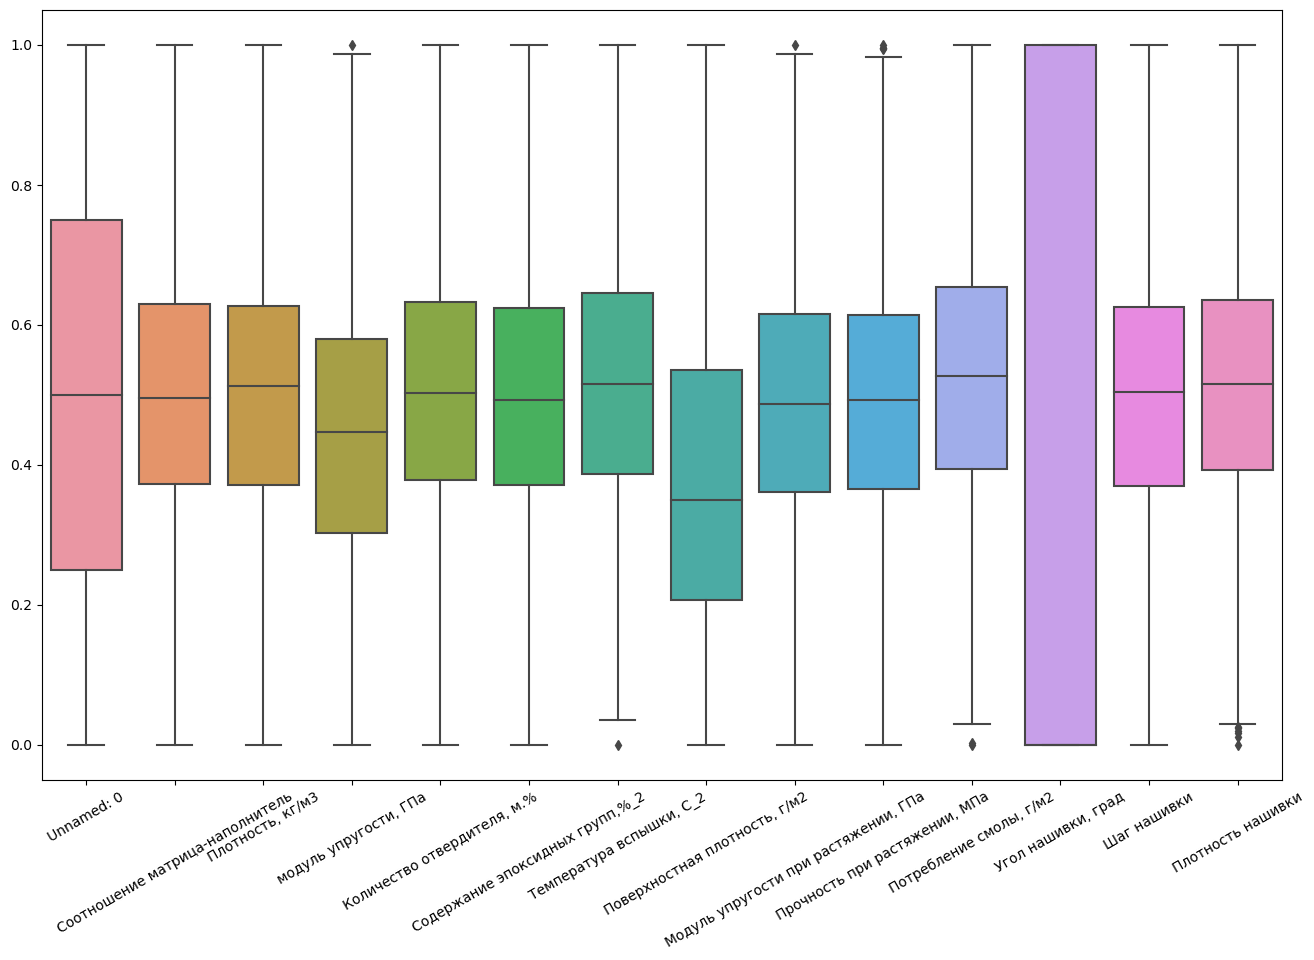

In [26]:
plt.figure(figsize = (16,10))
ax = sns.boxplot(data = df_minmax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

<AxesSubplot:ylabel='Density'>

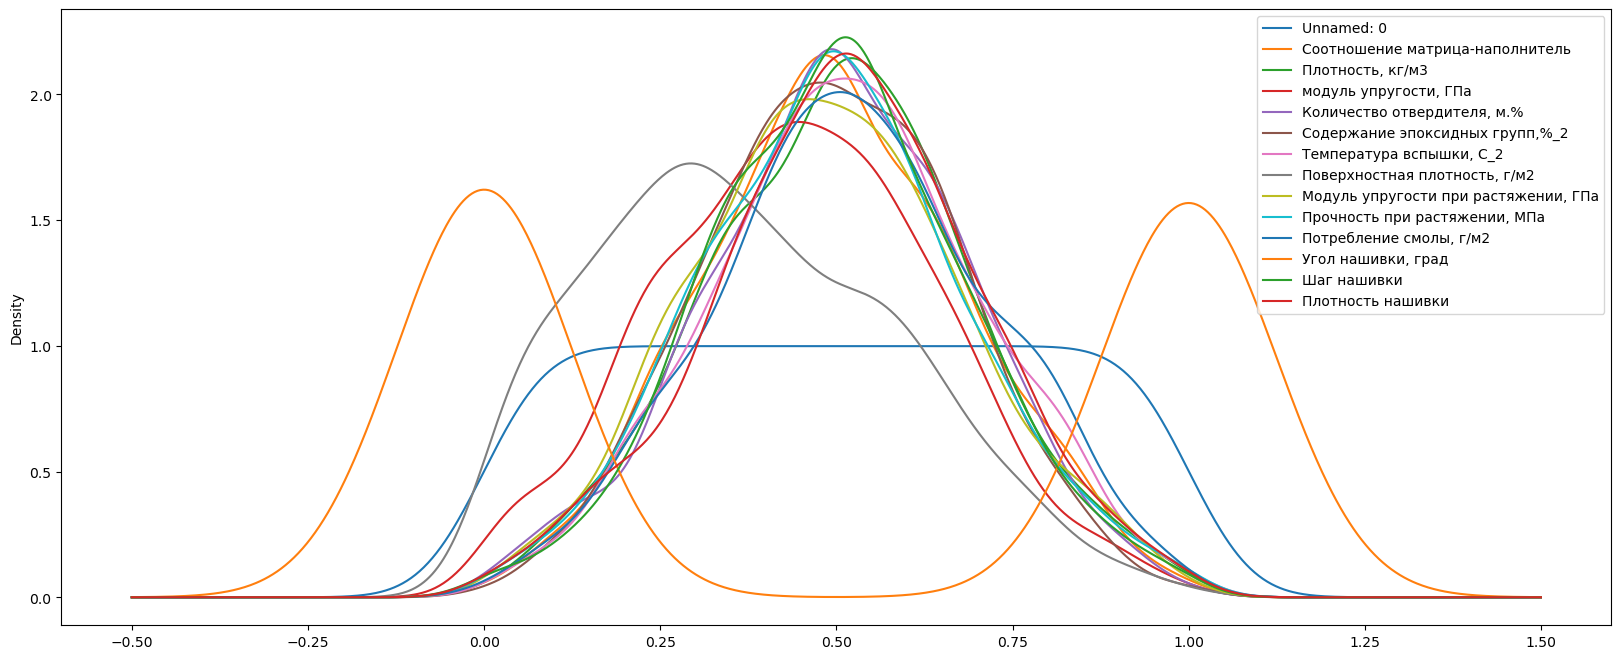

In [28]:
fig, ax = plt.subplots(figsize = (20, 8))
df_minmax.plot(kind = 'kde', ax = ax)

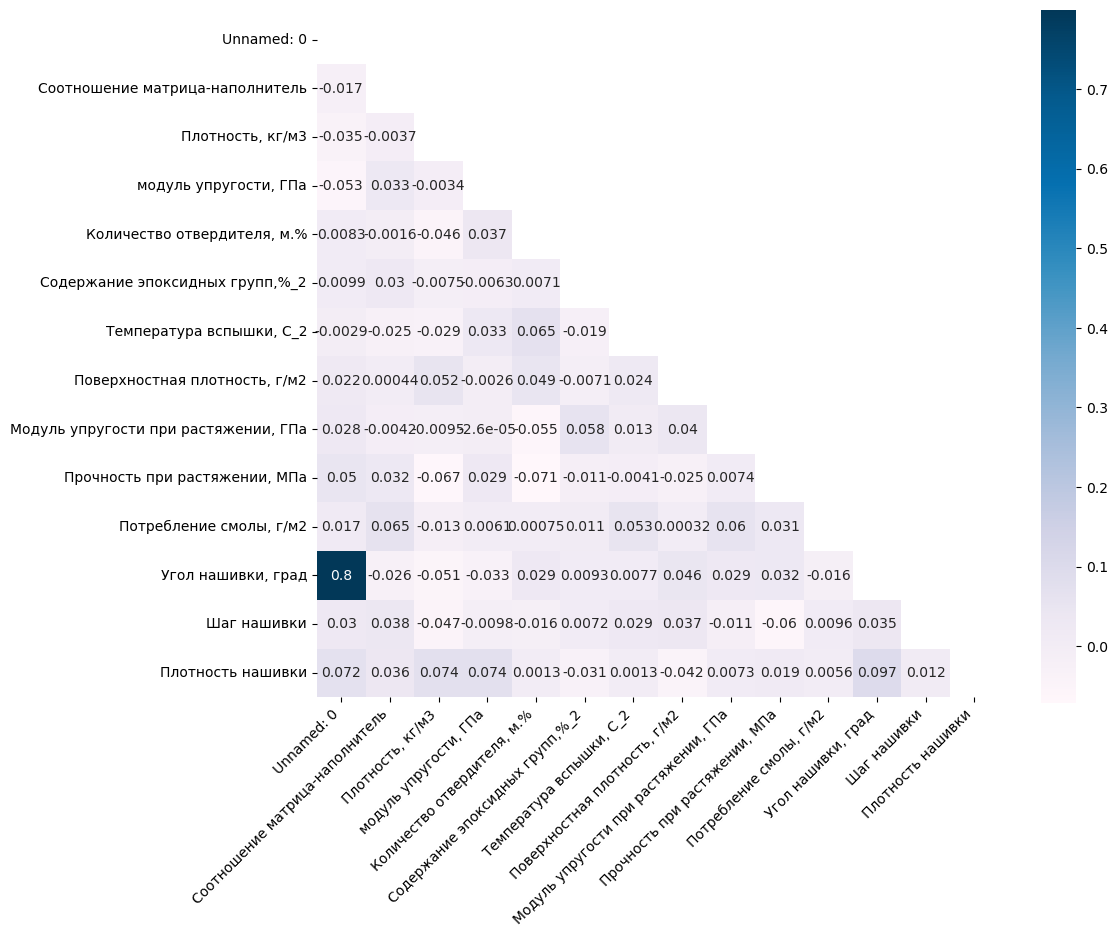

In [29]:
mask = np.triu(df_minmax.corr())
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(df_minmax.corr(), mask = mask, annot = True, square = True, cmap = 'PuBu')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [42]:
#Нормализуем данные с помощью Normalizer()
normalizer = Normalizer()
res = normalizer.fit_transform(df)
df_norm = pd.DataFrame(res, columns = df.columns)
df_norm.describe()

Unnamed: 0  Соотношение матрица-наполнитель  Плотность, кг/м3  \
count  1023.000000                      1023.000000       1023.000000   
mean      0.150576                         0.000869          0.587395   
std       0.086860                         0.000279          0.063592   
min       0.000000                         0.000161          0.442195   
25%       0.074775                         0.000673          0.543392   
50%       0.150130                         0.000859          0.583706   
75%       0.224565                         0.001050          0.628309   
max       0.354189                         0.001803          0.812795   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean                0.217122                     0.032934   
std                 0.094394                     0.008811   
min                 0.000701                     0.009464   
25%                 0.148649                     0.027118   
50%                 0.217621                     0.032744   
75%                 0.284295                     0.038937   
max                 0.524824                     0.062843   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                          0.006618                  0.085063   
std                           0.000996                  0.014718   
min                           0.004098                  0.049217   
25%                           0.005897                  0.074991   
50%                           0.006565                  0.083891   
75%                           0.007269                  0.094982   
max                           0.010546                  0.143003   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                        0.142087                              0.021810   
std                         0.082268                              0.002444   
min                         0.000229                              0.015914   
25%                         0.079175                              0.020091   
50%                         0.135470                              0.021616   
75%                         0.199805                              0.023394   
max                         0.414069                              0.030433   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                        0.719939                 0.064810   
std                         0.071313                 0.018250   
min                         0.462892                 0.017223   
25%                         0.676974                 0.051918   
50%                         0.729230                 0.064612   
75%                         0.772438                 0.076864   
max                         0.874715                 0.122192   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean             0.012988     0.002048           0.017066  
std              0.013352     0.000799           0.003735  
min              0.000000     0.000000           0.007138  
25%              0.000000     0.001485           0.014577  
50%              0.000000     0.002022           0.017015  
75%              0.026185     0.002559           0.019385  
max              0.036567     0.004517           0.029960

[Text(0, 0, 'Unnamed: 0'),
 Text(1, 0, 'Соотношение матрица-наполнитель'),
 Text(2, 0, 'Плотность, кг/м3'),
 Text(3, 0, 'модуль упругости, ГПа'),
 Text(4, 0, 'Количество отвердителя, м.%'),
 Text(5, 0, 'Содержание эпоксидных групп,%_2'),
 Text(6, 0, 'Температура вспышки, С_2'),
 Text(7, 0, 'Поверхностная плотность, г/м2'),
 Text(8, 0, 'Модуль упругости при растяжении, ГПа'),
 Text(9, 0, 'Прочность при растяжении, МПа'),
 Text(10, 0, 'Потребление смолы, г/м2'),
 Text(11, 0, 'Угол нашивки, град'),
 Text(12, 0, 'Шаг нашивки'),
 Text(13, 0, 'Плотность нашивки')]

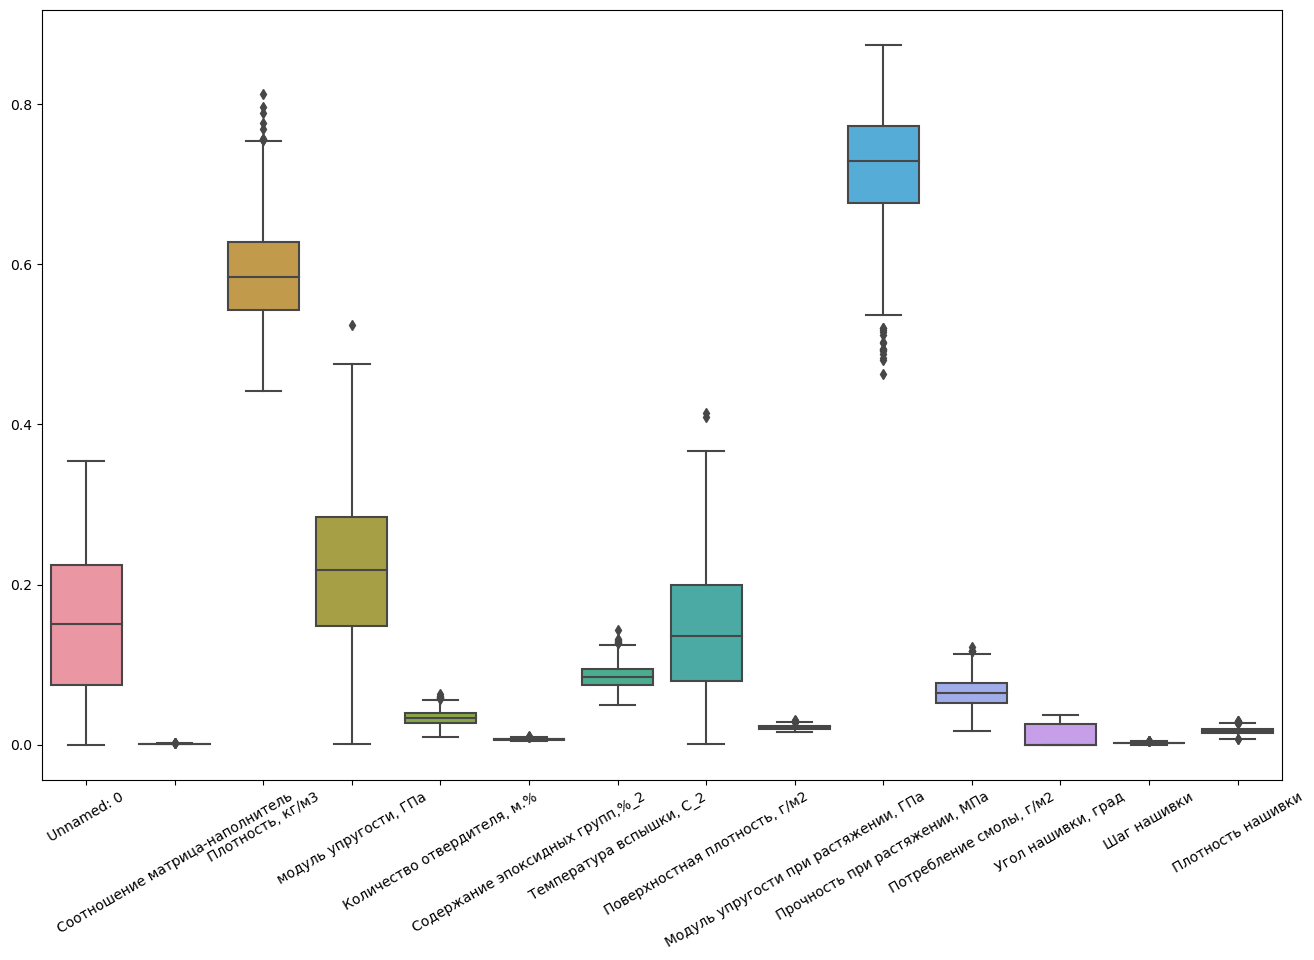

In [38]:
plt.figure(figsize = (16,10))
ax = sns.boxplot(data = df_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

<AxesSubplot:ylabel='Density'>

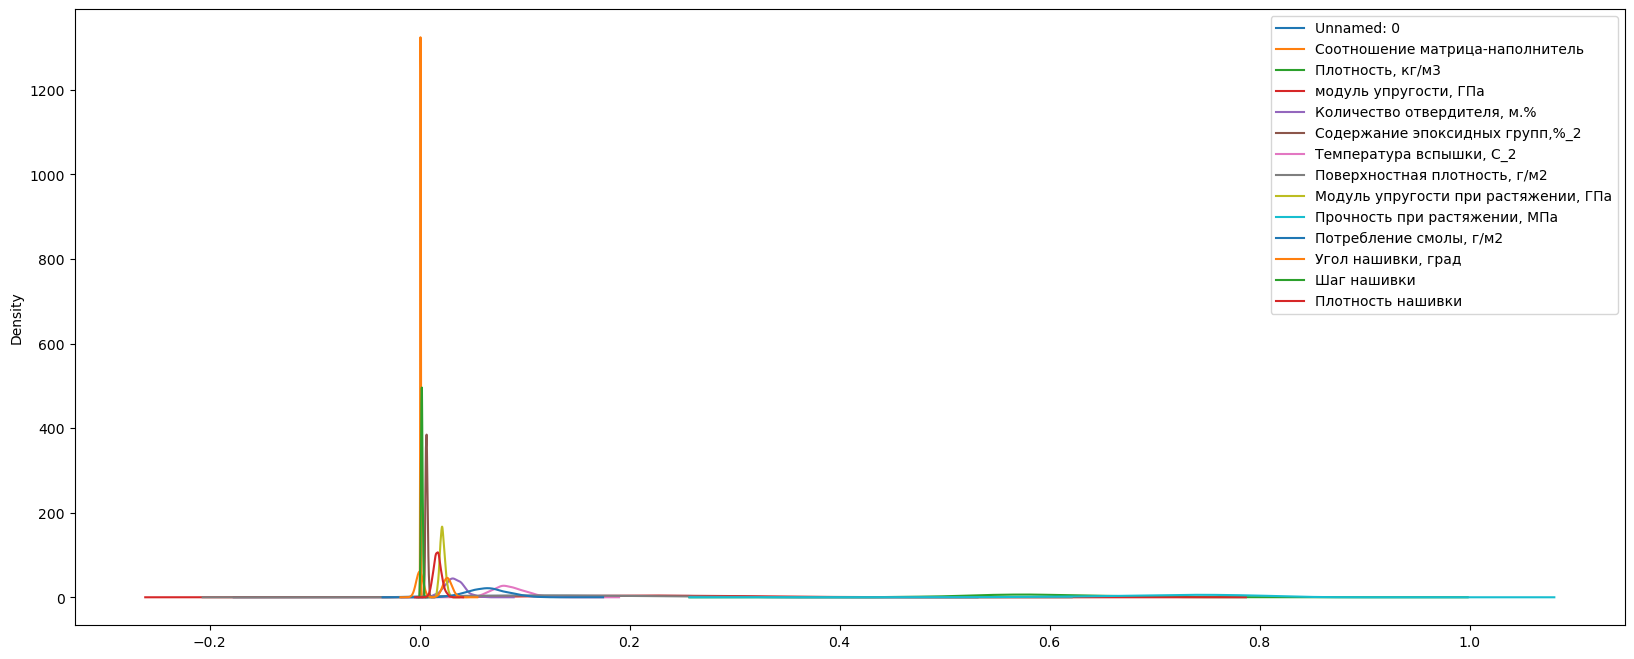

In [32]:
fig, ax = plt.subplots(figsize = (20, 8))
df_norm.plot(kind = 'kde', ax = ax)

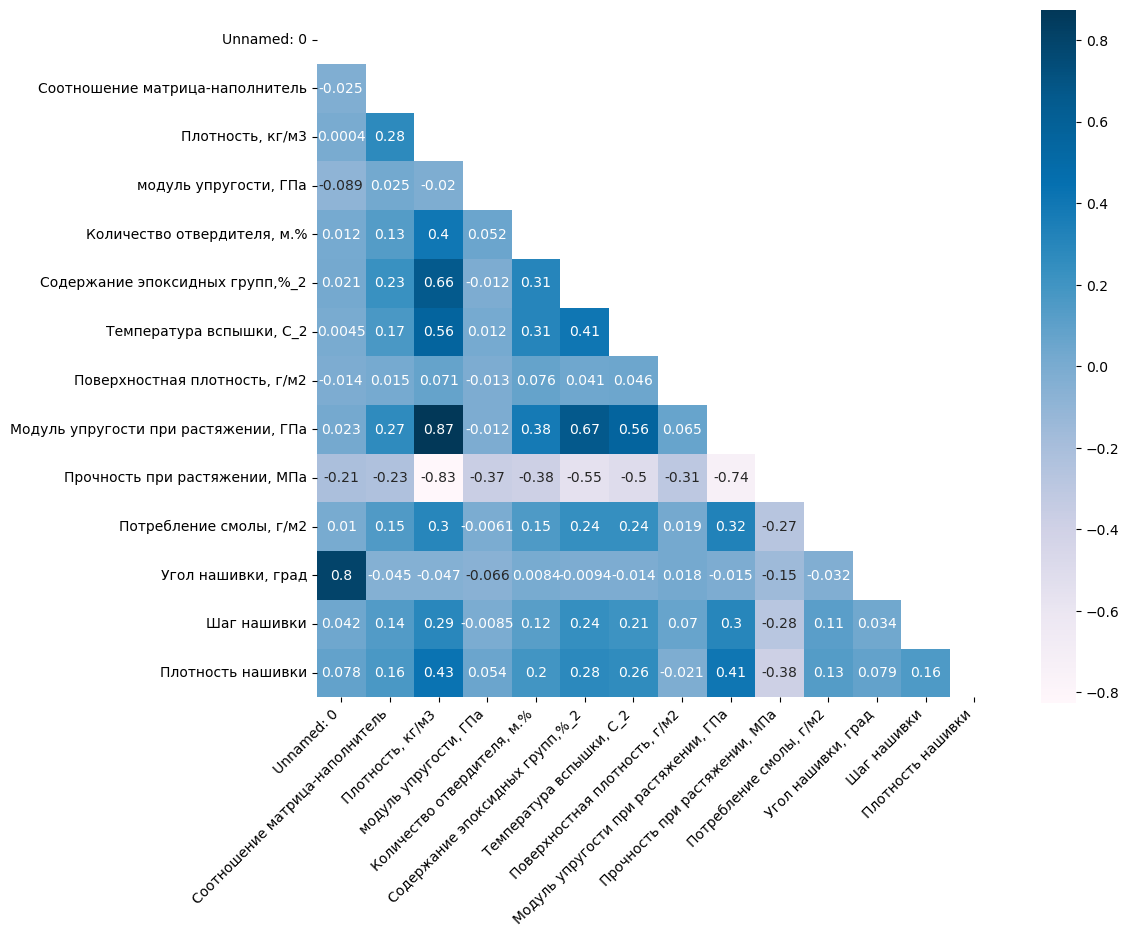

In [40]:
mask = np.triu(df_norm.corr())
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(df_norm.corr(), mask = mask, annot = True, square = True, cmap = 'PuBu')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [43]:
#Нормализуем данные с помощью RobustScaler()
Rscaler = RobustScaler()
result_3 = Rscaler.fit_transform(df)
df_rscaler = pd.DataFrame(result_3, columns = df.columns)
df_rscaler.describe()

Unnamed: 0  Соотношение матрица-наполнитель  Плотность, кг/м3  \
count  1.023000e+03                      1023.000000       1023.000000   
mean  -3.472838e-17                         0.015283         -0.027804   
std    5.781976e-01                         0.726795          0.737228   
min   -1.000000e+00                        -1.921451         -2.008127   
25%   -5.000000e-01                        -0.476758         -0.550667   
50%    0.000000e+00                         0.000000          0.000000   
75%    5.000000e-01                         0.523242          0.449333   
max    1.000000e+00                         1.961174          1.915989   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean               -0.002696                    -0.000184   
std                 0.713811                     0.733465   
min                -1.610445                    -1.977875   
25%                -0.522390                    -0.486429   
50%                 0.000000                     0.000000   
75%                 0.477610                     0.513571   
max                 1.990772                     1.960468   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                          0.003262                  0.000983   
std                           0.708114                  0.739564   
min                          -1.952893                 -2.001757   
25%                          -0.482785                 -0.498446   
50%                           0.000000                  0.000000   
75%                           0.517215                  0.501554   
max                           2.009524                  1.882405   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                        0.069591                              0.011411   
std                         0.655122                              0.754078   
min                        -1.060594                             -1.911153   
25%                        -0.434151                             -0.490094   
50%                         0.000000                              0.000000   
75%                         0.565849                              0.509906   
max                         1.976723                              2.020447   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                        0.012675                -0.014179   
std                         0.763674                 0.750789   
min                        -1.981154                -2.023903   
25%                        -0.511321                -0.510836   
50%                         0.000000                 0.000000   
75%                         0.488679                 0.489164   
max                         2.047018                 1.820588   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean             0.491691    -0.010874          -0.007104  
std              0.500175     0.721404           0.778616  
min              0.000000    -1.976196          -2.113303  
25%              0.000000    -0.523065          -0.505857  
50%              0.000000     0.000000           0.000000  
75%              1.000000     0.476935           0.494143  
max              1.000000     1.951924           1.991188

Этот масштабатор удаляет медиану и масштабирует данные в соответствии с диапазоном квантилей (по умолчанию IQR: межквартильный диапазон). IQR представляет собой диапазон между 1-м квартилем (25-й квантиль) и 3-м квартилем (75-й квантиль).

Центрирование и масштабирование выполняются независимо для каждой функции путем вычисления соответствующей статистики по выборкам в обучающем наборе. Медиана и межквартильный диапазон затем сохраняются для использования в более поздних данных с использованием transformметода.

[Text(0, 0, 'Unnamed: 0'),
 Text(1, 0, 'Соотношение матрица-наполнитель'),
 Text(2, 0, 'Плотность, кг/м3'),
 Text(3, 0, 'модуль упругости, ГПа'),
 Text(4, 0, 'Количество отвердителя, м.%'),
 Text(5, 0, 'Содержание эпоксидных групп,%_2'),
 Text(6, 0, 'Температура вспышки, С_2'),
 Text(7, 0, 'Поверхностная плотность, г/м2'),
 Text(8, 0, 'Модуль упругости при растяжении, ГПа'),
 Text(9, 0, 'Прочность при растяжении, МПа'),
 Text(10, 0, 'Потребление смолы, г/м2'),
 Text(11, 0, 'Угол нашивки, град'),
 Text(12, 0, 'Шаг нашивки'),
 Text(13, 0, 'Плотность нашивки')]

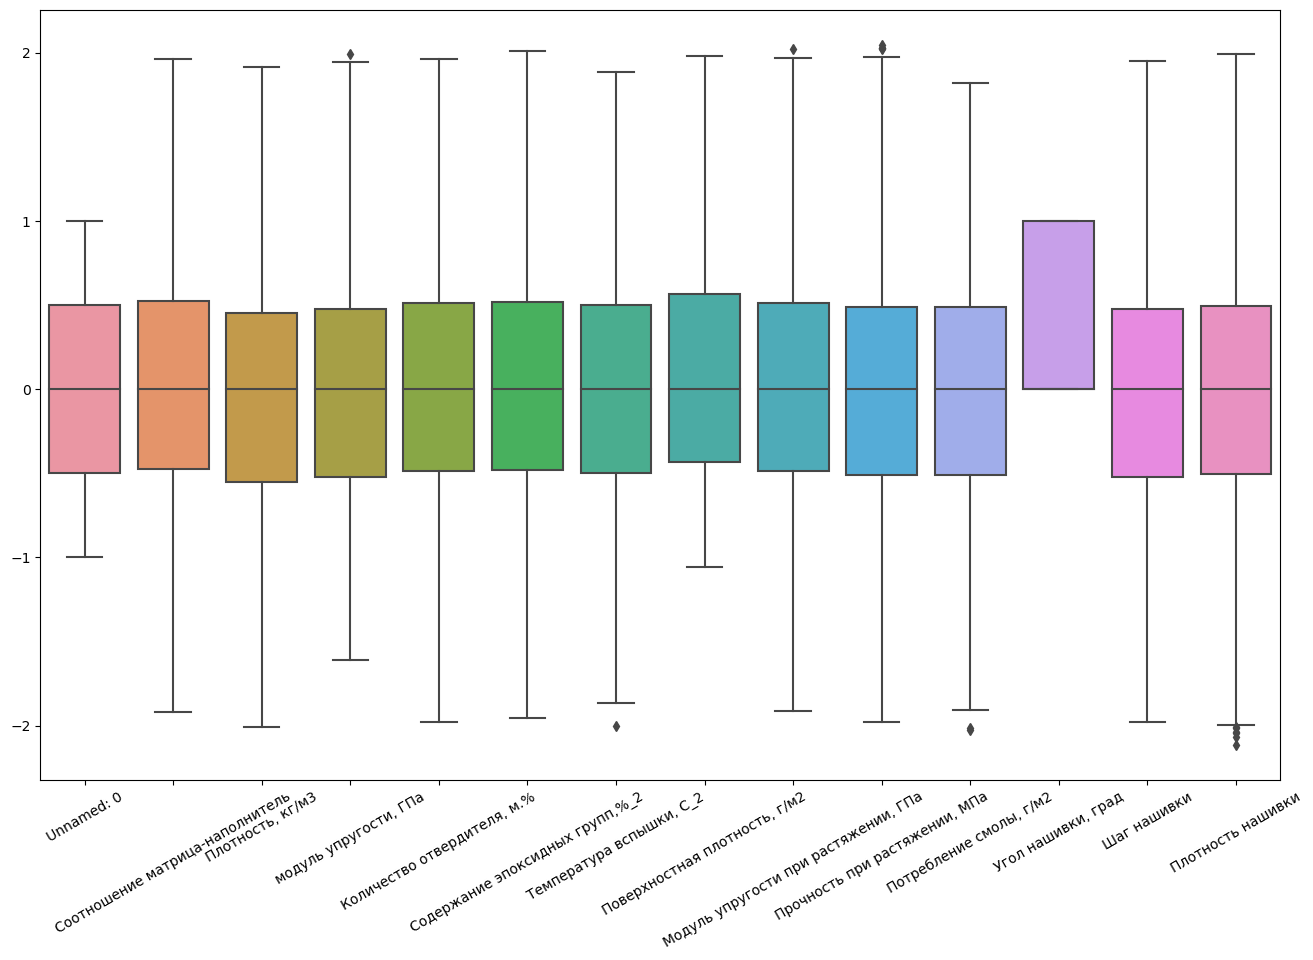

In [37]:
plt.figure(figsize = (16,10))
ax = sns.boxplot(data = df_rscaler)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

<AxesSubplot:ylabel='Density'>

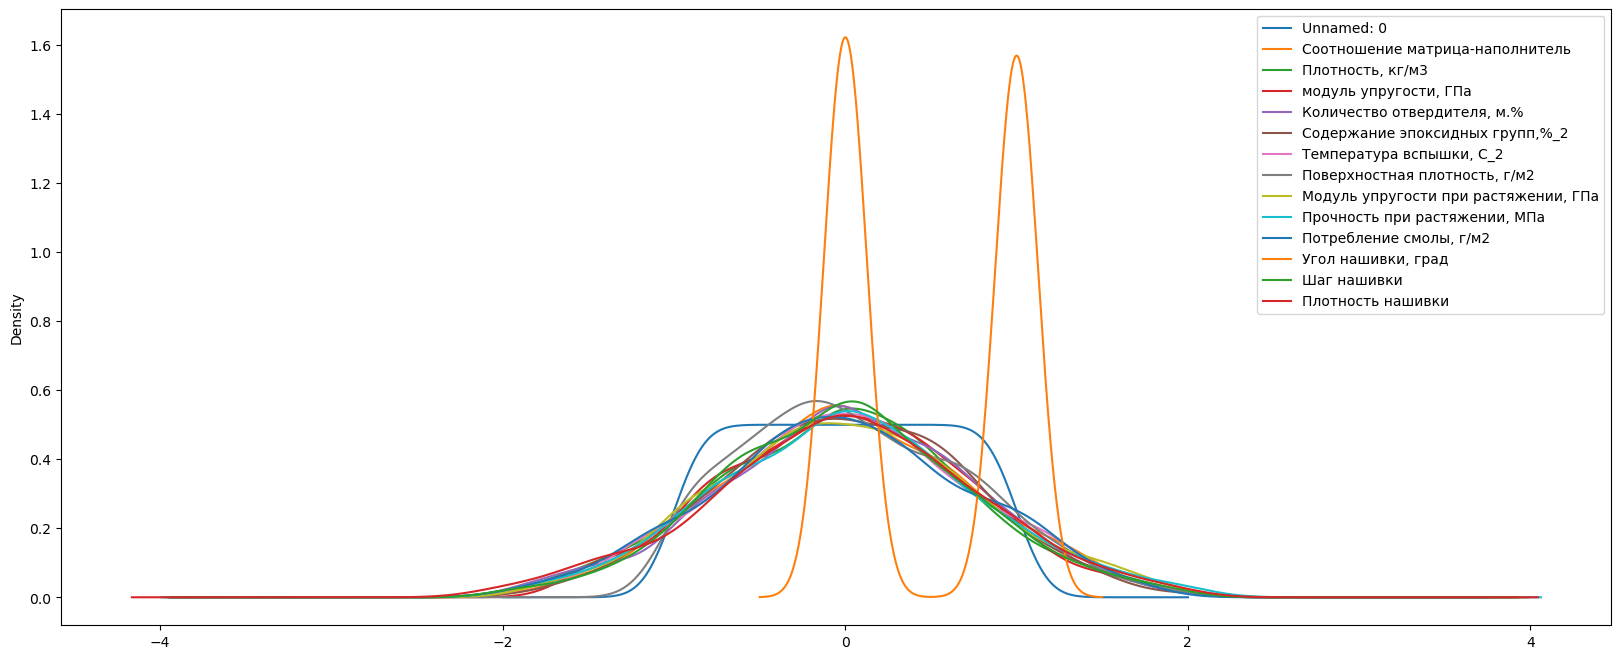

In [39]:
fig, ax = plt.subplots(figsize = (20, 8))
df_rscaler.plot(kind = 'kde', ax = ax)

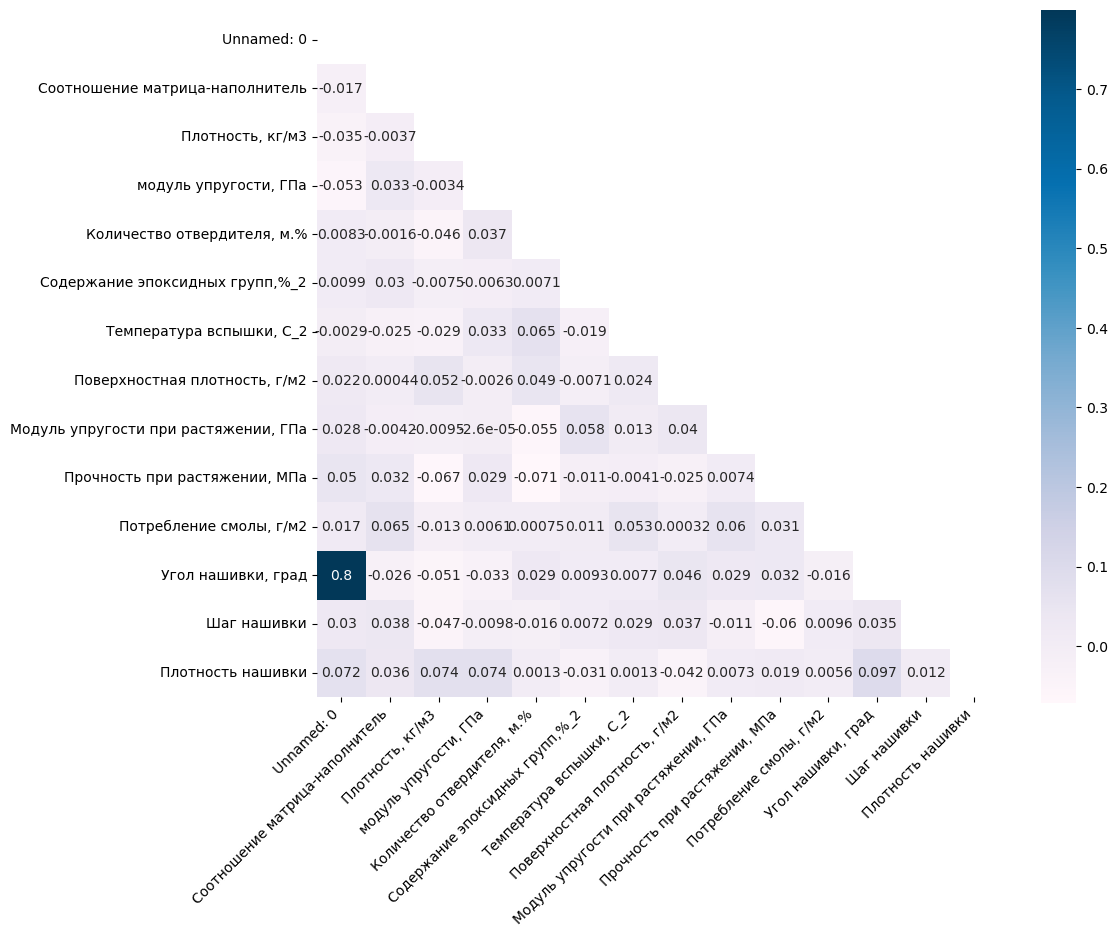

In [41]:
mask = np.triu(df_rscaler.corr())
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(df_rscaler.corr(), mask = mask, annot = True, square = True, cmap = 'PuBu')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Стандартизация данных

In [44]:
X1 = df_minmax.copy()
X2 = df_norm.copy()
X3 = df_rscaler.copy()

In [69]:
df_std_X1 = StandardScaler().fit_transform(X1)
df_standart_1 = pd.DataFrame(df_std_X1)
df_standart_1.columns = df_minmax.copy().columns

<AxesSubplot:ylabel='Density'>

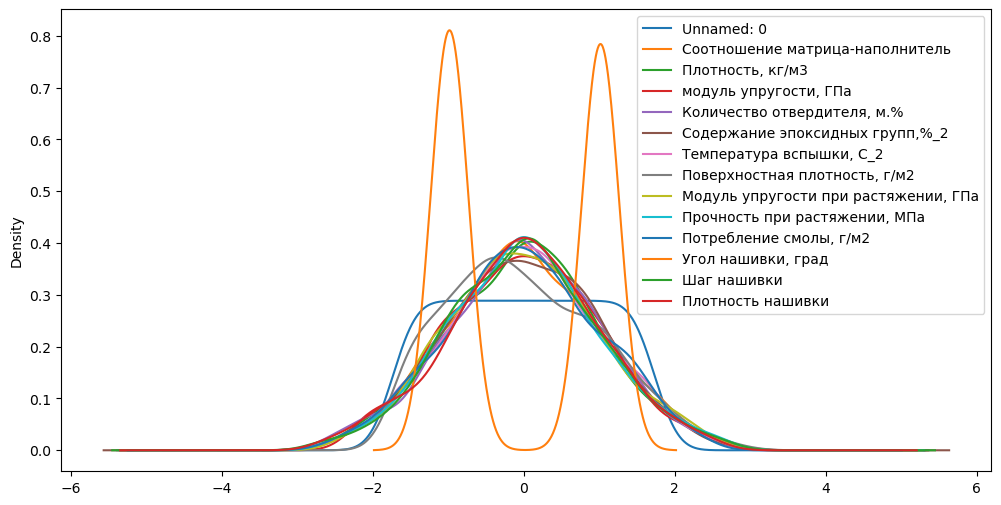

In [70]:
fig, ax = plt.subplots(figsize = (12, 6))
df_standart_1.plot(kind = 'kde', ax = ax)

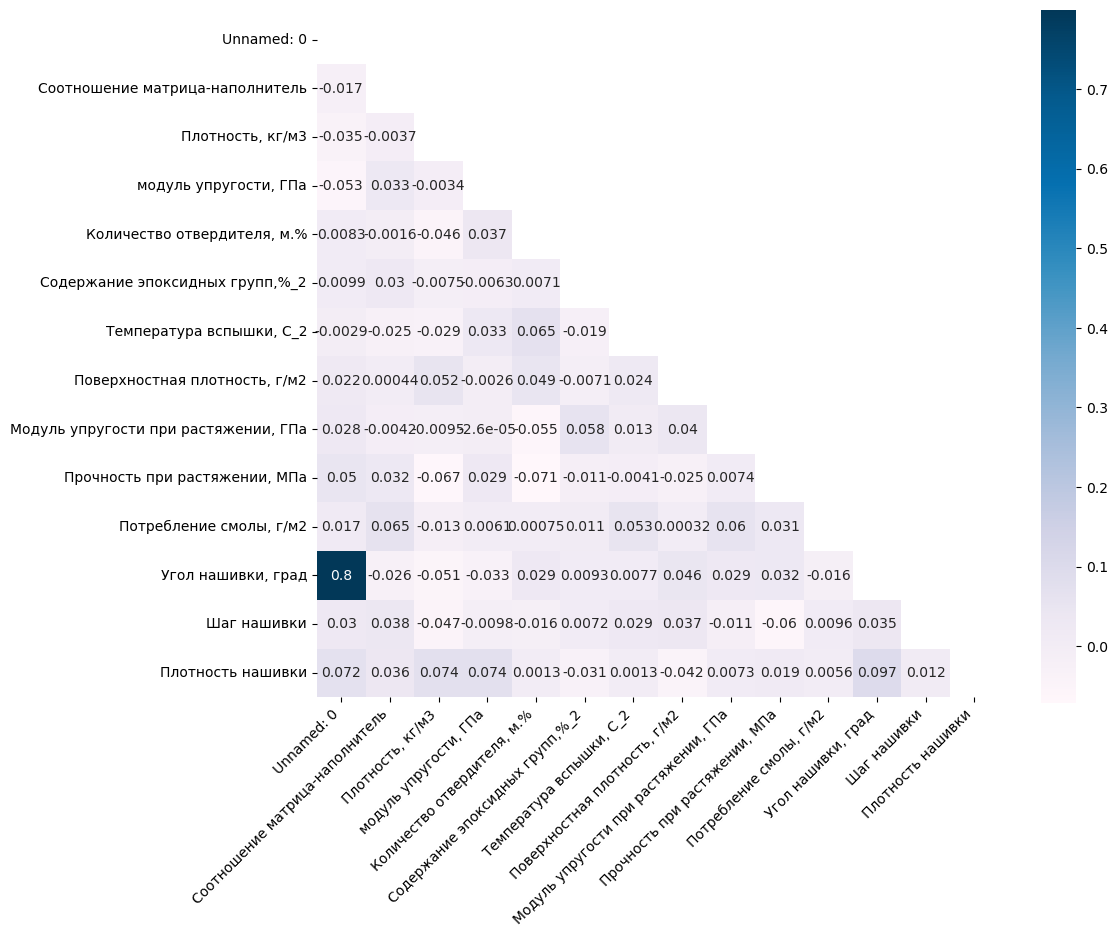

In [71]:
mask = np.triu(df_standart_1.corr())
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_standart_1.corr(), mask=mask, annot=True, square=True, cmap='PuBu')
plt.xticks(rotation=45, ha='right')
plt.show()

In [72]:
df_std_X2 = StandardScaler().fit_transform(X2)
df_standart_2 = pd.DataFrame(df_std_X2)
df_standart_2.columns = df_norm.copy().columns

<AxesSubplot:ylabel='Density'>

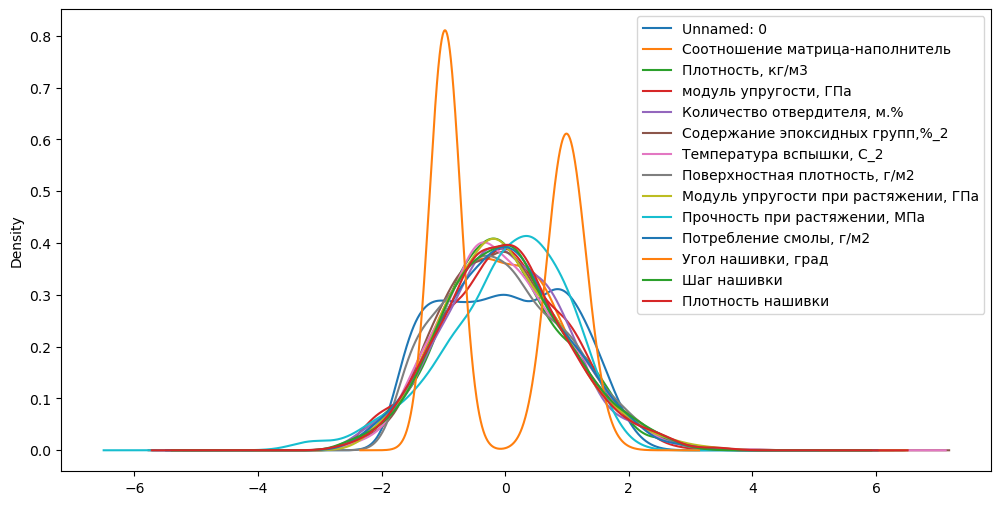

In [73]:
fig, ax = plt.subplots(figsize = (12, 6))
df_standart_2.plot(kind = 'kde', ax = ax)

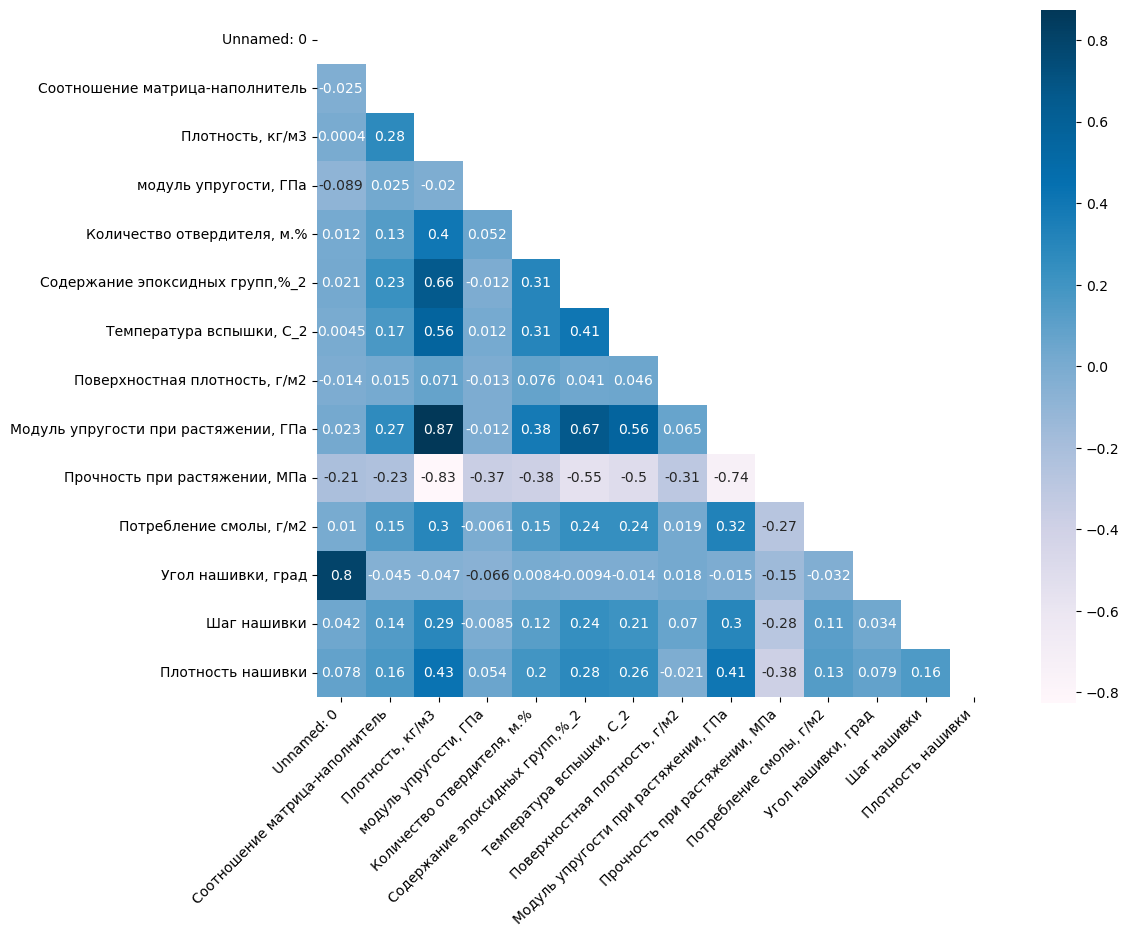

In [74]:
mask = np.triu(df_standart_2.corr())
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_standart_2.corr(), mask=mask, annot=True, square=True, cmap='PuBu')
plt.xticks(rotation=45, ha='right')
plt.show()

In [75]:
df_std_X3 = StandardScaler().fit_transform(X3)
df_standart_3 = pd.DataFrame(df_std_X3)
df_standart_3.columns = df_rscaler.copy().columns

<AxesSubplot:ylabel='Density'>

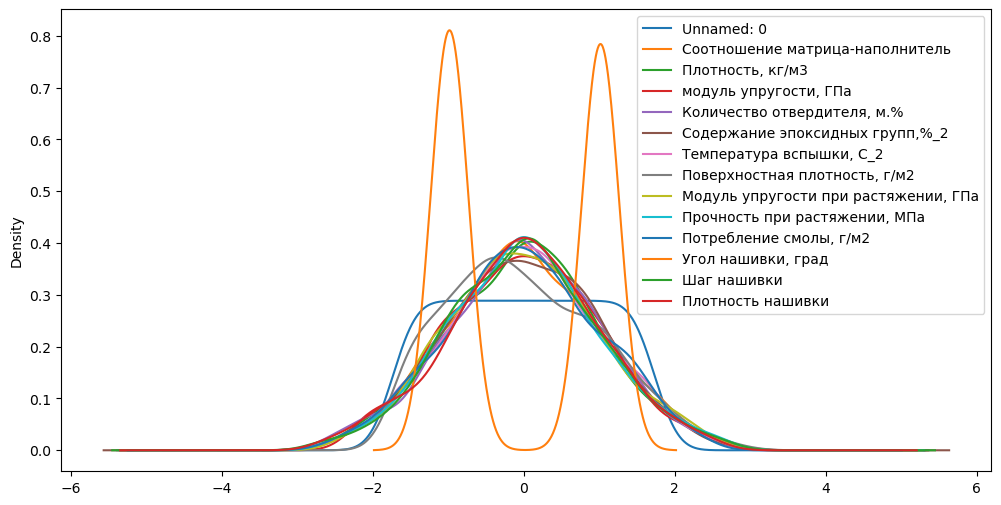

In [76]:
fig, ax = plt.subplots(figsize = (12, 6))
df_standart_3.plot(kind = 'kde', ax = ax)

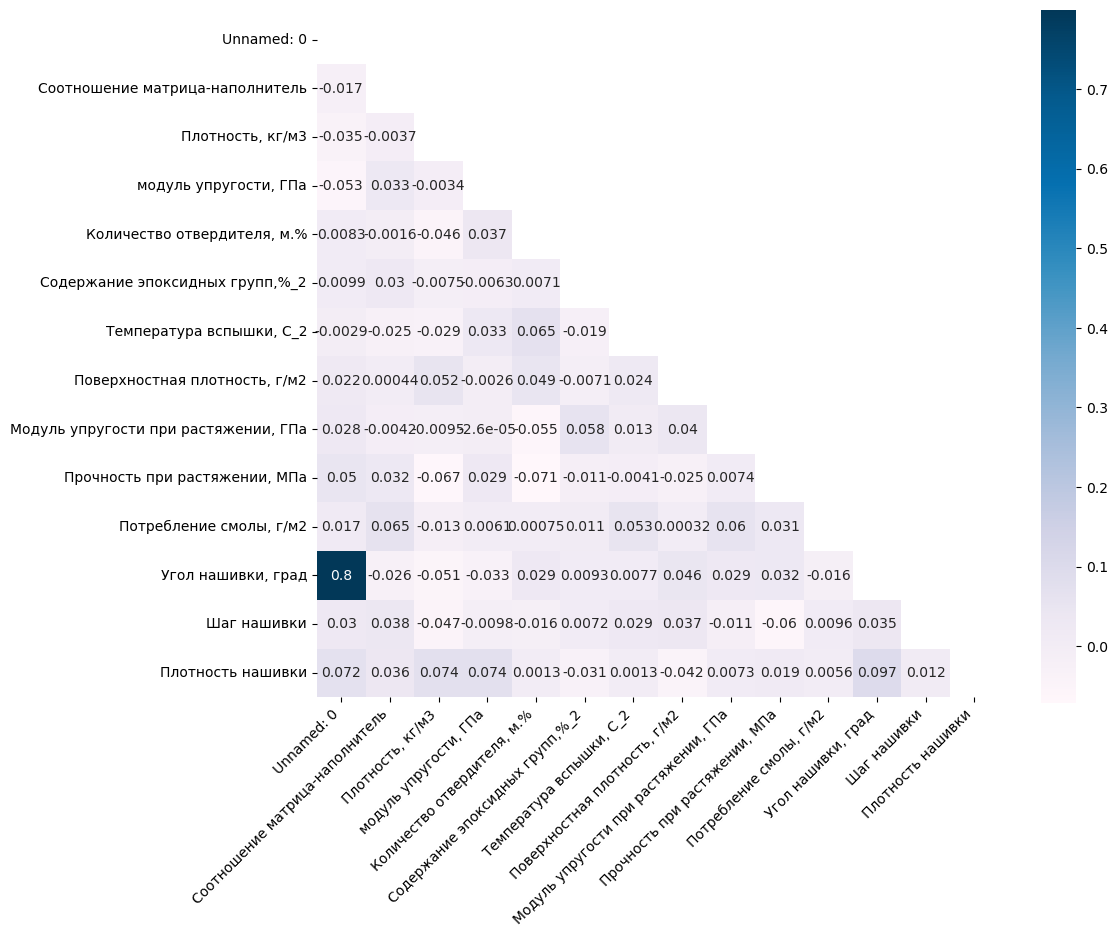

In [77]:
mask = np.triu(df_standart_3.corr())
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_standart_3.corr(), mask=mask, annot=True, square=True, cmap='PuBu')
plt.xticks(rotation=45, ha='right')
plt.show()